Adapted from 06-623 lecture notes (John Kitchin, 2018).

In [1]:
pkg load optim
set(0,'defaultAxesFontSize',20)
set(0,'defaultLineLineWidth',5)

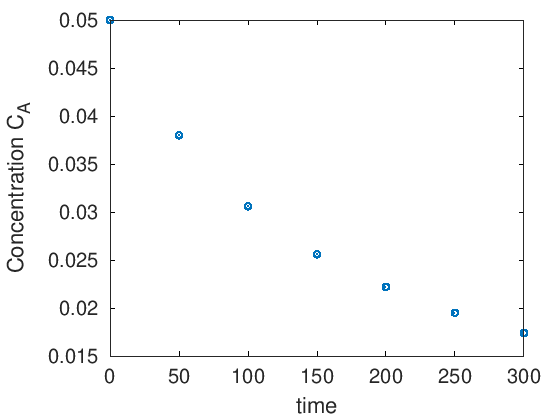

In [39]:

time = [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]';
Ca = [50.0, 38.0, 30.6, 25.6, 22.2, 19.5, 17.4]'*1e-3;

plot(time,Ca,'o')
xlabel('time')
ylabel('Concentration C_A')


# Linear regression



In linear regression, we seek to find models in the form $y = a_{0} f_{0}(x) + a_{1} f_{1}(x) + ... + a_{n} f_{n}(x) + \epsilon$, where $a_{i}$ are coefficients to be determined, and &epsilon; are the residual errors. We call this linear regression because the model is linear in the unknown coefficients $a_{i}$. The functions can be any function of $x$. In the function `polyfit` these functions are polynomials in $x$.

If we are given some data as pairs of (x, y), we can construct a set of equations of the form:

$[f_{0}(x_{i}), f_{1}(x_{i}), ..., f_{n}(x_{i})]\cdot[a_{0}, a_{1}, ...,  a_{n}]^T = y_{i}$

There will be one of these equations for every data point, so we end up with a matrix equation that looks like:

$\mathbf{X} \mathbf{a} = \mathbf{y}$

There are *usually* more data points than in the vector of $\mathbf{a}$, so the shapes of these arrays are not suitable to solve directly. You can of course set up an objective function and use `fminunc`, but there is a better approach.

To be a little more specific, suppose we have $m$ pairs of (x, y) data points, and we want to fit a model containing $n$ parameters. Then, the dimensions of the $\mathbf{X}$ will be (m, n), the dimensions of $\mathbf{a}$ will be (n, 1), and the dimensions of $\mathbf{y}$ will be (m, 1).  We have more equations than unknowns here, and we cannot use `A\b` because $\mathbf{X}$ is not square. 

We can modify the equation though if we *left multiply* each side of the equation by $\mathbf{X}^T$.

$\mathbf{X}^T \mathbf{X} \mathbf{a} = \mathbf{X}^T \mathbf{y}$

The array $\mathbf{X}^T \mathbf{X}$ now has the shape (n, m) \* (m, n) = (n, n). The right hand side $\mathbf{X}^T \mathbf{y}$ has a shape of (n, m) \* (n, 1) = (n, 1), and $\mathbf{a}$ is still (n, 1). This new matrix equation can be solved efficiently with `A\b`. We will not prove this, but solving this modified equation *is equivalent* to finding the set of parameters that minimizes the summed squared errors: $\sum (\mathbf{X}^T\mathbf{X} \cdot \mathbf{a} - \mathbf{X}^T\mathbf{y})^2$.

The parameters are then found by:



In [34]:
X'*X\X'*y # Do not run this.

error: 'y' undefined near line 1 column 7


An alternative form is called the normal equation: $\mathbf{a} = (\mathbf{X}^T\cdot\mathbf{X})^{-1}\mathbf{X}^T \mathbf{y}$. This is symbolically correct, but relies on the inverse which is expensive to compute for large systems. It is not used practically, instead the equations are solved efficiently using a different algorithm.




## An example of polynomial fitting



Our goal in this example is to fit a polynomial to some time-dependent concentration data.



In [42]:
# import numpy as np

time = [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]';
Ca = [50.0, 38.0, 30.6, 25.6, 22.2, 19.5, 17.4]'*1e-3;

Fit a fourth order polynomial to this data and determine the confidence interval for each parameter. This data is from example 5-1 in Fogler, Elements of Chemical Reaction Engineering.

We want the equation $Ca(t) = b0 + b1*t + b2*t^2 + b3*t^3$ fit to the data in the least squares sense. We can write this in a linear algebra form as: $\mathbf{T} \mathbf{p} = \mathbf{Ca}$ where $\mathbf{T}$ is a matrix of columns $[1, t, t^2, t^3]$, and $\mathbf{p}$ is a column vector of the fitting parameters. We want to solve for the $\mathbf{p}$ vector and estimate the confidence intervals.

First, we setup the array of function values, and then we solve for the paramters.



In [53]:
X = [time.^0, time, time.^2, time.^3, time.^4];

X

X =

            1            0            0            0            0
            1           50         2500       125000      6250000
            1          100        10000      1000000    100000000
            1          150        22500      3375000    506250000
            1          200        40000      8000000   1600000000
            1          250        62500     15625000   3906250000
            1          300        90000     27000000   8100000000



a =

   0.0498714285714
  -0.0002744761905
   0.0000009328571
  -0.0000000012667



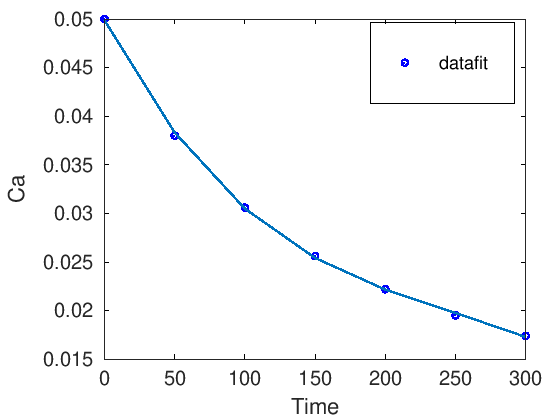

In [50]:
a = X'*X\(X'*Ca)
% print(a)

%matplotlib inline

plot(time, Ca, 'bo', time, X * a)
xlabel('Time')
ylabel('Ca')
legend(['data', 'fit'])

In [51]:
pars = polyfit(time, Ca, 3)

pars =

  -0.0000000012667   0.0000009328571  -0.0002744761905   0.0498714285714



We previously claimed that solving this equation was equivalent to minimizing the summed squared errors. Here we demonstrate that is consistent with our observation for the first parameter.



err = [](0x0)


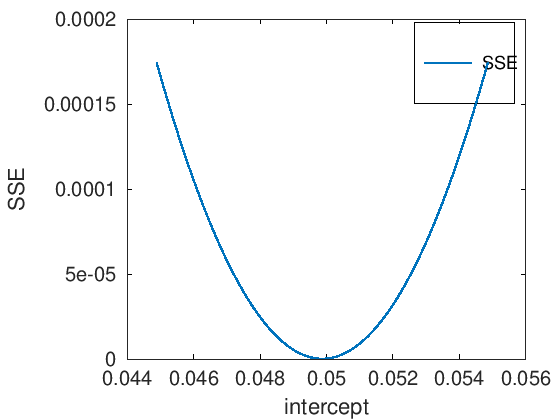

In [52]:
P = linspace(0.9 * a(1), 1.1 * a(1));

err=[]
for p=P
    err(end+1)=sum((X * [p, a(2), a(3), a(4)]'- Ca).^2);
end

plot(P,err)

xlabel('intercept')
ylabel('SSE')
legend(['SSE'])

The key points to note are that the rank is equal to the number of parameters we are estimating, which means we have enough information to get pretty good estimates of the parameters.




## Confidence intervals on the parameters



The confidence intervals reflect the range of values we are confident the true parameter lies in. Remember we are only *estimating* these parameters from a small amount of data.

The degrees of freedom is roughly equal to the number of data points minus the number of parameters.

We define $\sigma^2 = SSE / dof$ where $SSE$ is the summed squared error, and $dof$ is the degrees of freedom.

The covariance matrix is defined as $(\mathbf{X}^T \mathbf{X})^{-1}$. Finally, we compute the standard error on the parameters as:

$\mathbf{se} = \sqrt{diag(\sigma^2 cov)}$.

This will be an array with one element for each parameter. You can think of this standard error as the uncertainty in the mean value of each parameter.

The confidence intervals are finally computed by calculating a student t-value that accounts for the additional uncertainty we have because of the small number of degrees of freedom.



Luckily, there are already package routines to calculate this for us. 

In [54]:
pkg load statistics

#also regress in Matlab
[b, bint, r, rint, stats] = regress(Ca, X)

    regress at line 134 column 7
b =

   4.9990e-02
  -2.9785e-04
   1.3435e-06
  -3.4848e-09
   3.6970e-12

bint =

   4.9680e-02   5.0300e-02
  -3.1546e-04  -2.8023e-04
   1.0715e-06   1.6155e-06
  -4.9032e-09  -2.0665e-09
   1.3501e-12   6.0439e-12

r =

   0.0000097403
  -0.0000441558
   0.0000746753
  -0.0000519481
   0.0000032468
   0.0000129870
  -0.0000045455

rint =

  -0.000018059   0.000037540
  -0.000136820   0.000048508
   0.000028343   0.000121007
  -0.000237276   0.000133380
  -0.000321078   0.000327571
  -0.000190874   0.000216848
  -0.000050878   0.000041787

stats =

   9.9999e-01   3.8364e+04   2.6065e-05   5.2597e-09



# Nonlinear model fitting

We can also fit parameters for non-linear models. Essentially, we are trying to solve the same minimization problem we did two weeks ago - vary a set of parameters to minimize the error between the function and the data. Let's demonstrate this for the linear model above.

In [60]:
function y = linear_model(p, x)
    y = exp(-p(1)*x);
end

lsqcurvefit(@linear_model, [0.1],time,Ca )

ans =  0.064242


This is the same answer as with linear regression! The benefit here is that we can specify any function, such as solving an ODE for an engineering problem, or a thermodynamic model, etc.